In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['figure.dpi']=300
sns.set_theme(style='darkgrid',palette='rainbow')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [38]:
df=pd.read_csv('/content/exchange_rate.csv')
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


## **Data Preparation and Exploration**

In [39]:
df['Date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M', errors='coerce')
df

,date,Ex_rate,Date
0,01-01-1990 00:00,0.785500,1990-01-01
1,02-01-1990 00:00,0.781800,1990-01-02
2,03-01-1990 00:00,0.786700,1990-01-03
3,04-01-1990 00:00,0.786000,1990-01-04
4,05-01-1990 00:00,0.784900,1990-01-05
...,...,...,...
7583,06-10-2010 00:00,0.718494,2010-10-06
7584,07-10-2010 00:00,0.721839,2010-10-07
7585,08-10-2010 00:00,0.723197,2010-10-08
7586,09-10-2010 00:00,0.720825,2010-10-09


In [40]:
df.dtypes

,0
date,object
Ex_rate,float64
Date,datetime64[ns]


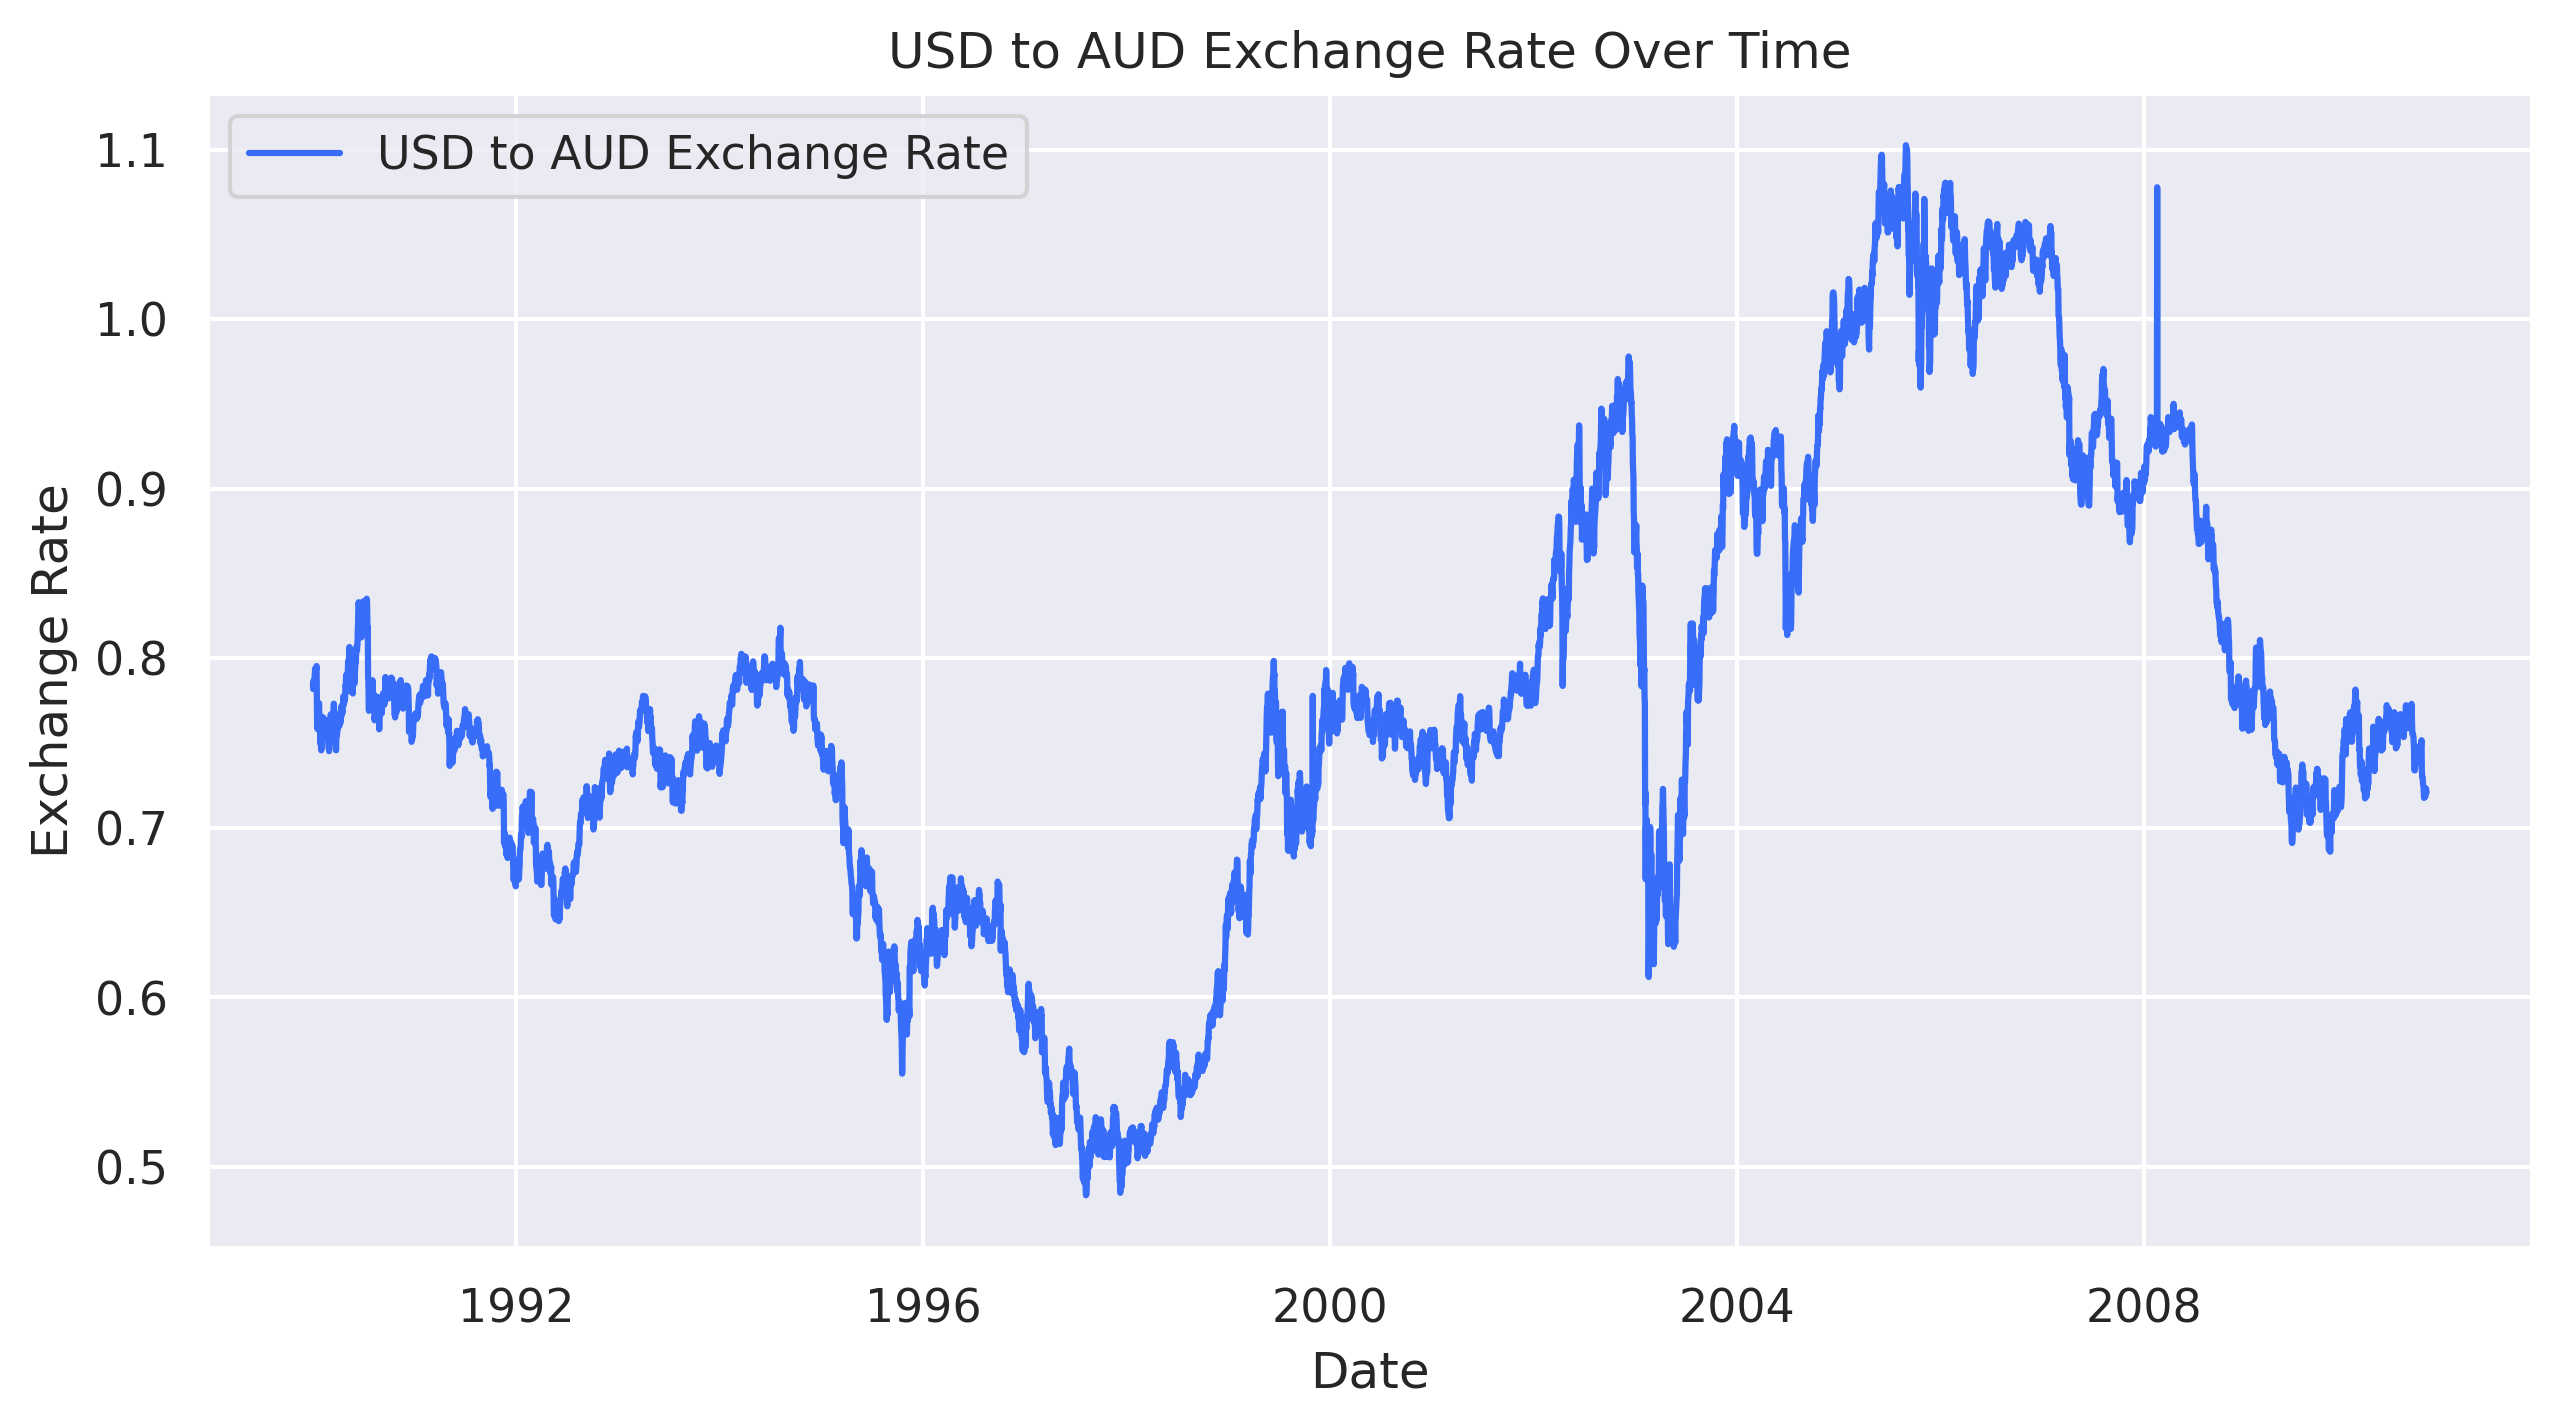

In [41]:


# Plot the exchange rate time series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Ex_rate'], label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [42]:
df.isnull().sum()

,0
date,0
Ex_rate,0
Date,0


## **Model Building - ARIMA**

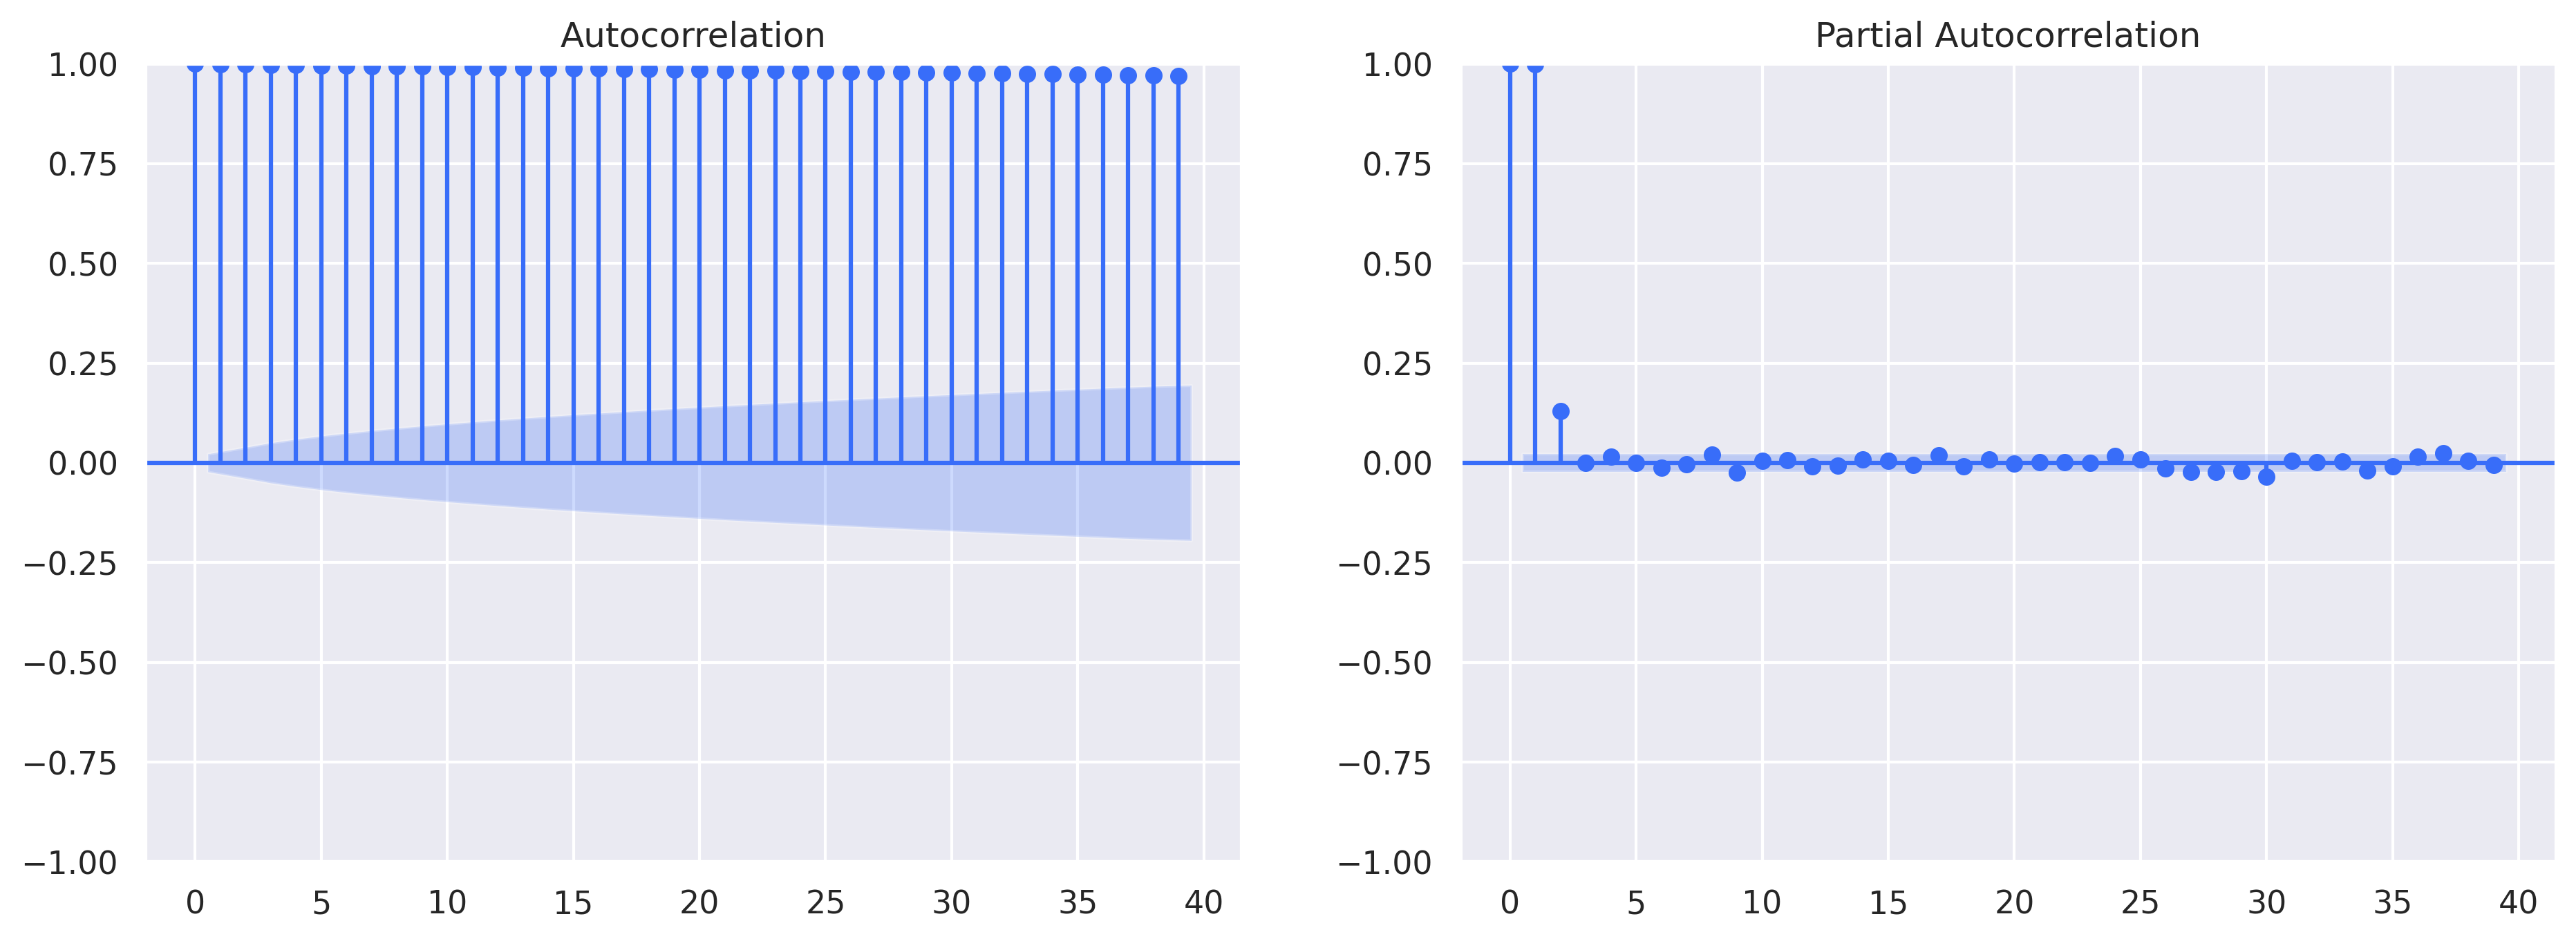

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df['Ex_rate'], ax=axes[0])
plot_pacf(df['Ex_rate'], ax=axes[1])
plt.show()

In [44]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model (replace p, d, q with chosen values)
model = ARIMA(df['Ex_rate'], order=(1,1,1))
arima_result = model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 09 Oct 2024   AIC                         -56102.322
Time:                        10:58:58   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

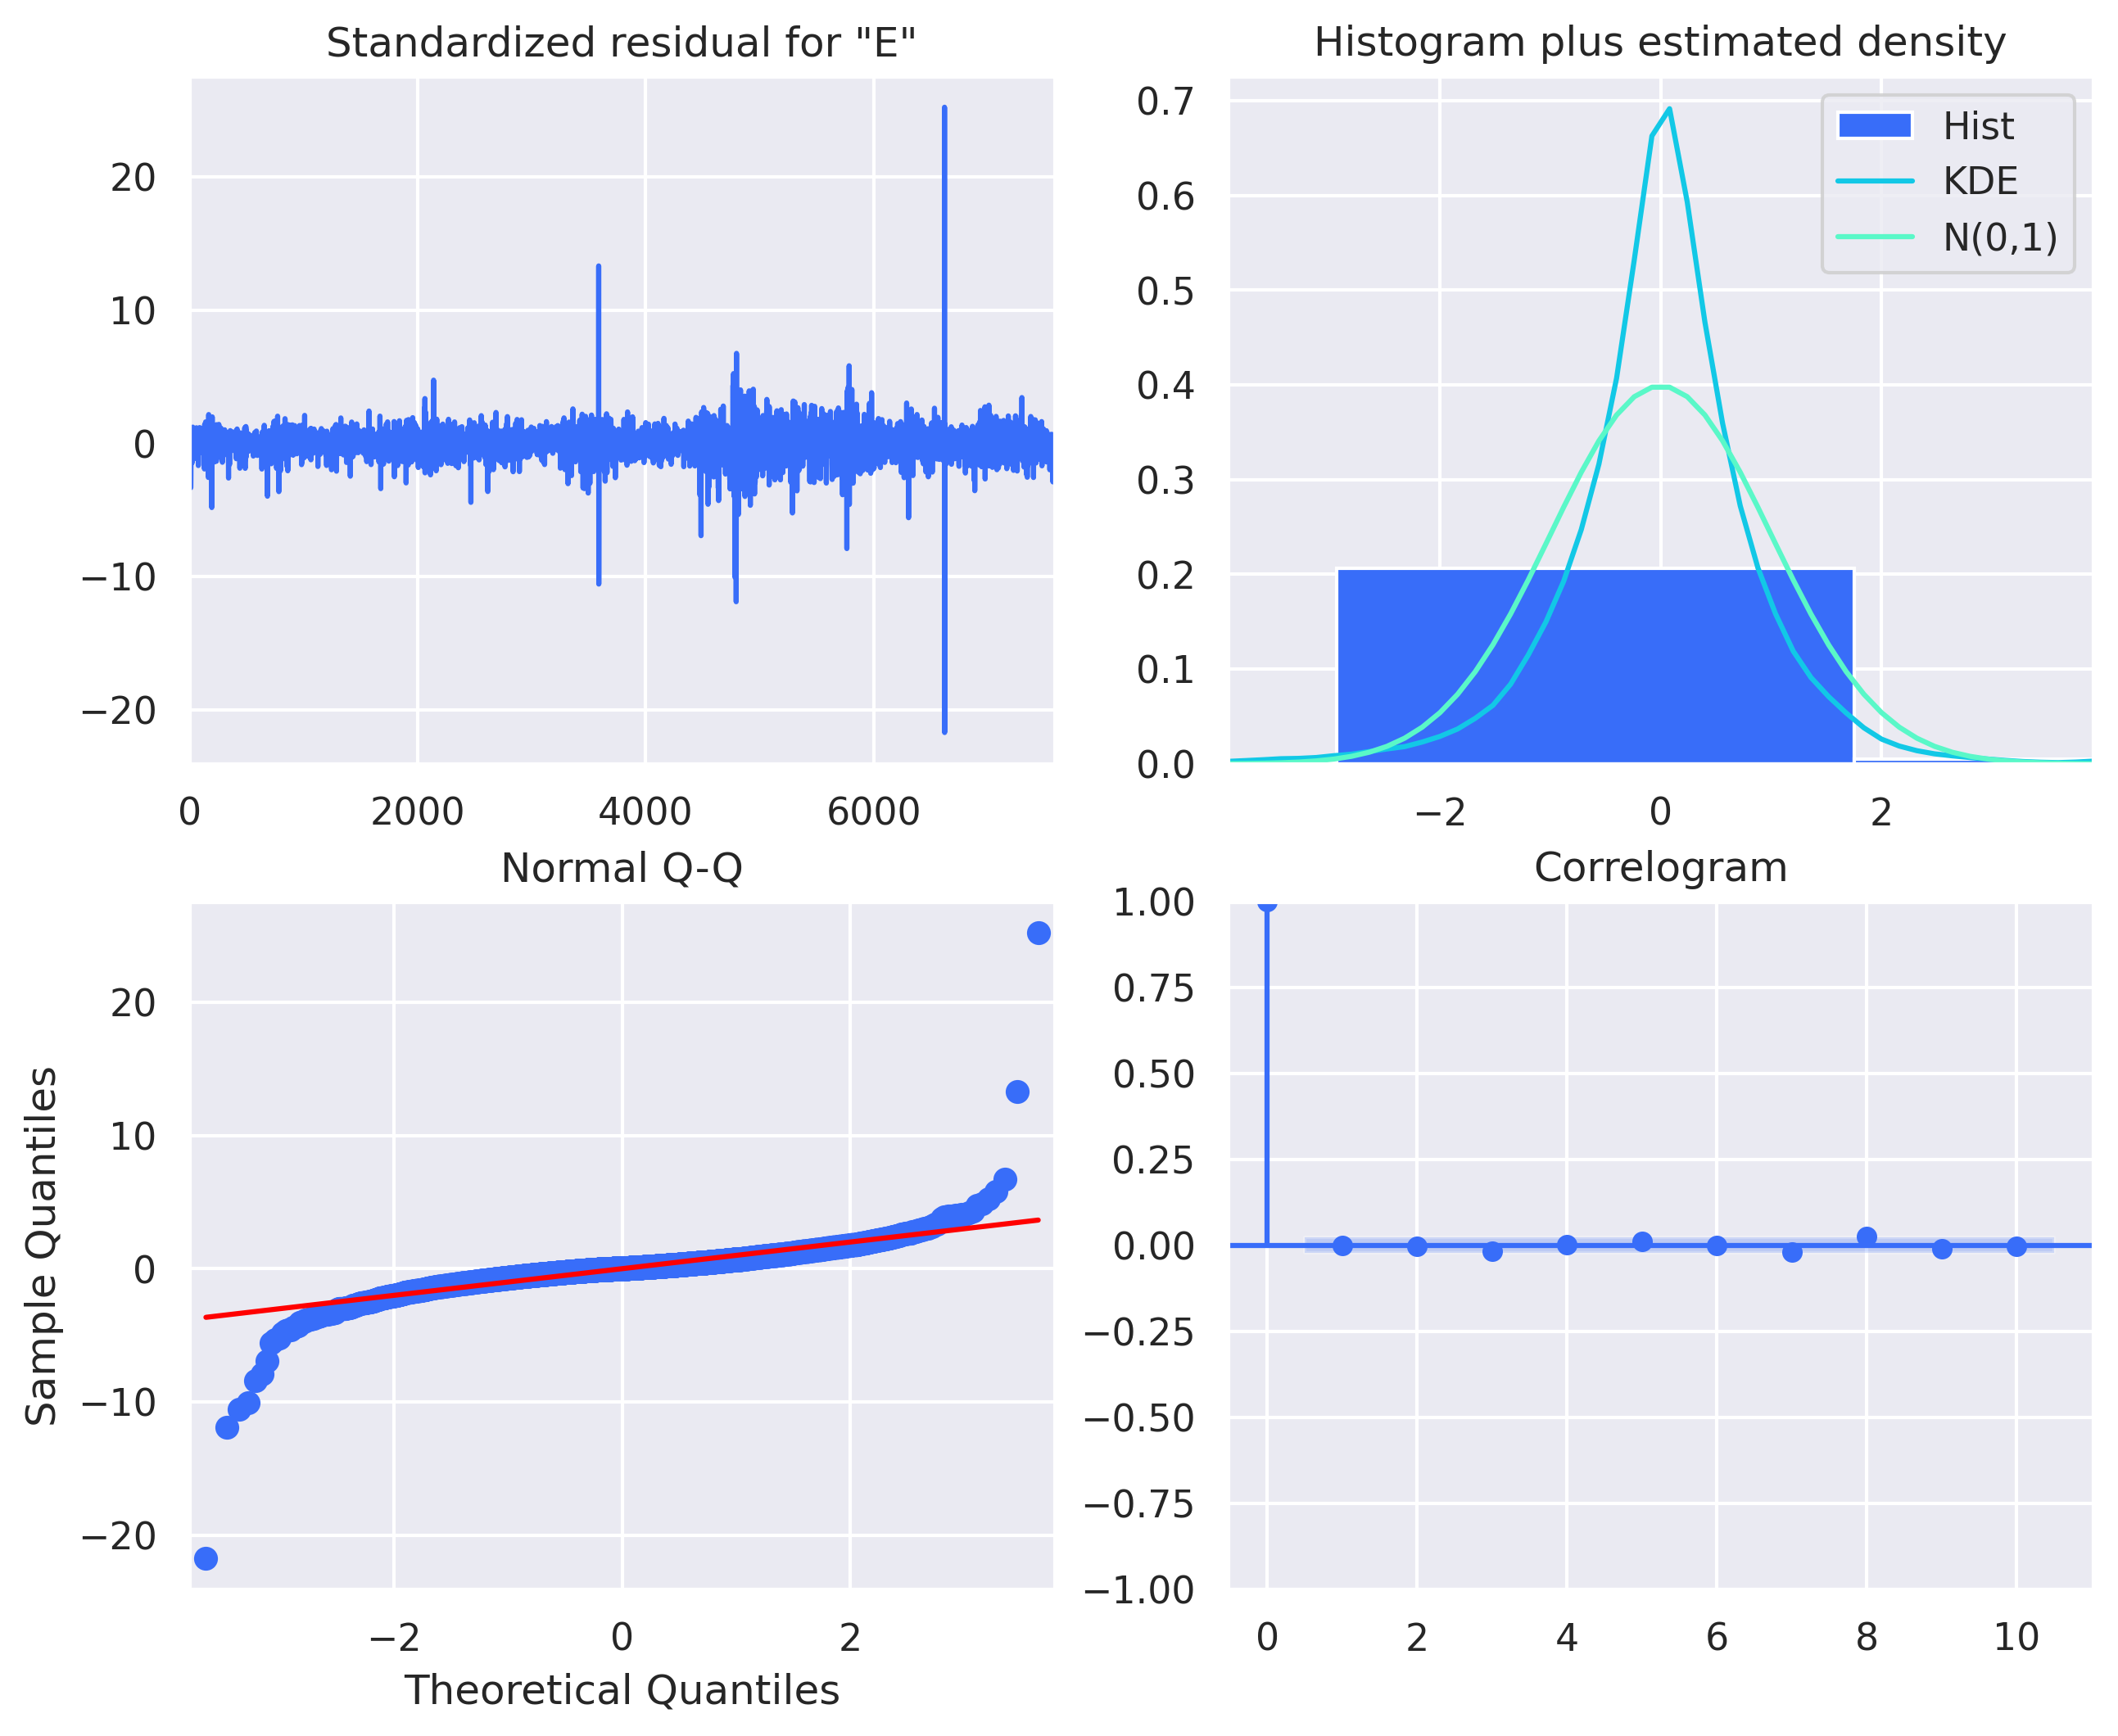

In [45]:
arima_result.plot_diagnostics(figsize=(10, 8))
plt.show()

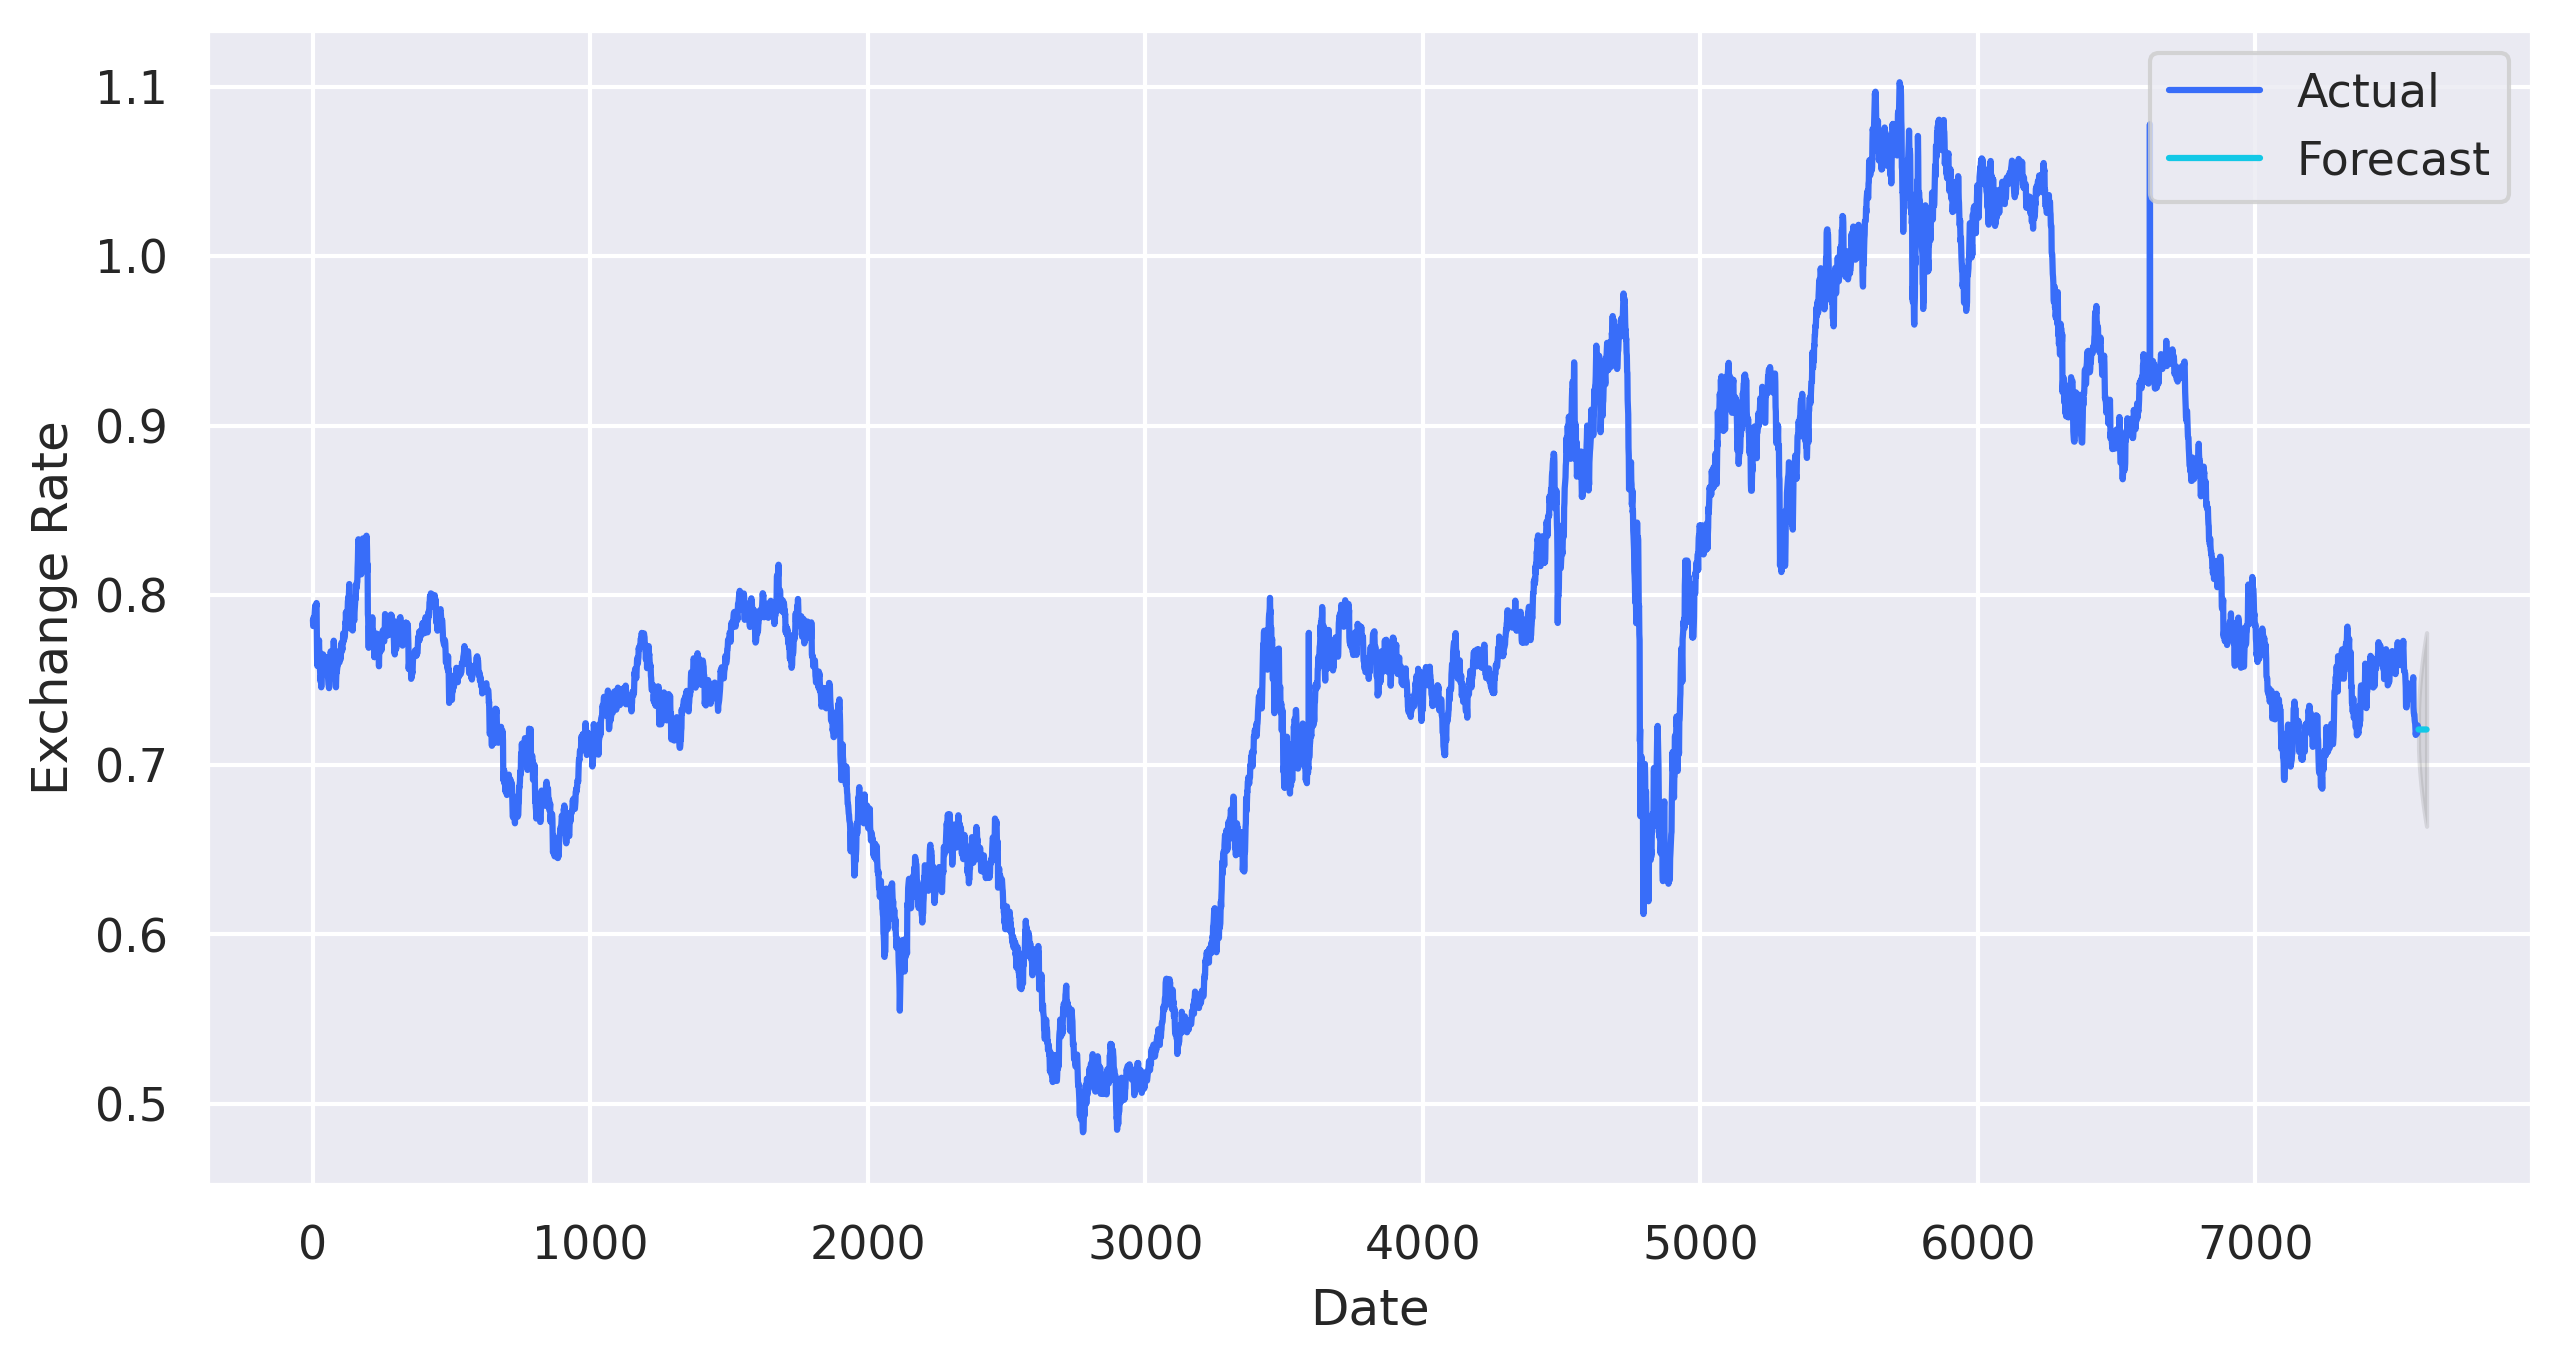

In [46]:
forecast = arima_result.get_forecast(steps=30)
forecast_ci = forecast.conf_int()

# Plot forecasts
plt.figure(figsize=(10, 5))
print(plt.plot(df['Ex_rate'], label='Actual'))
print(plt.plot(forecast.predicted_mean, label='Forecast'))
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

## **Model Building - Exponential Smoothing**

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt's Linear Model (Exponential Smoothing with trend)
holt_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
holt_result = holt_model.fit()

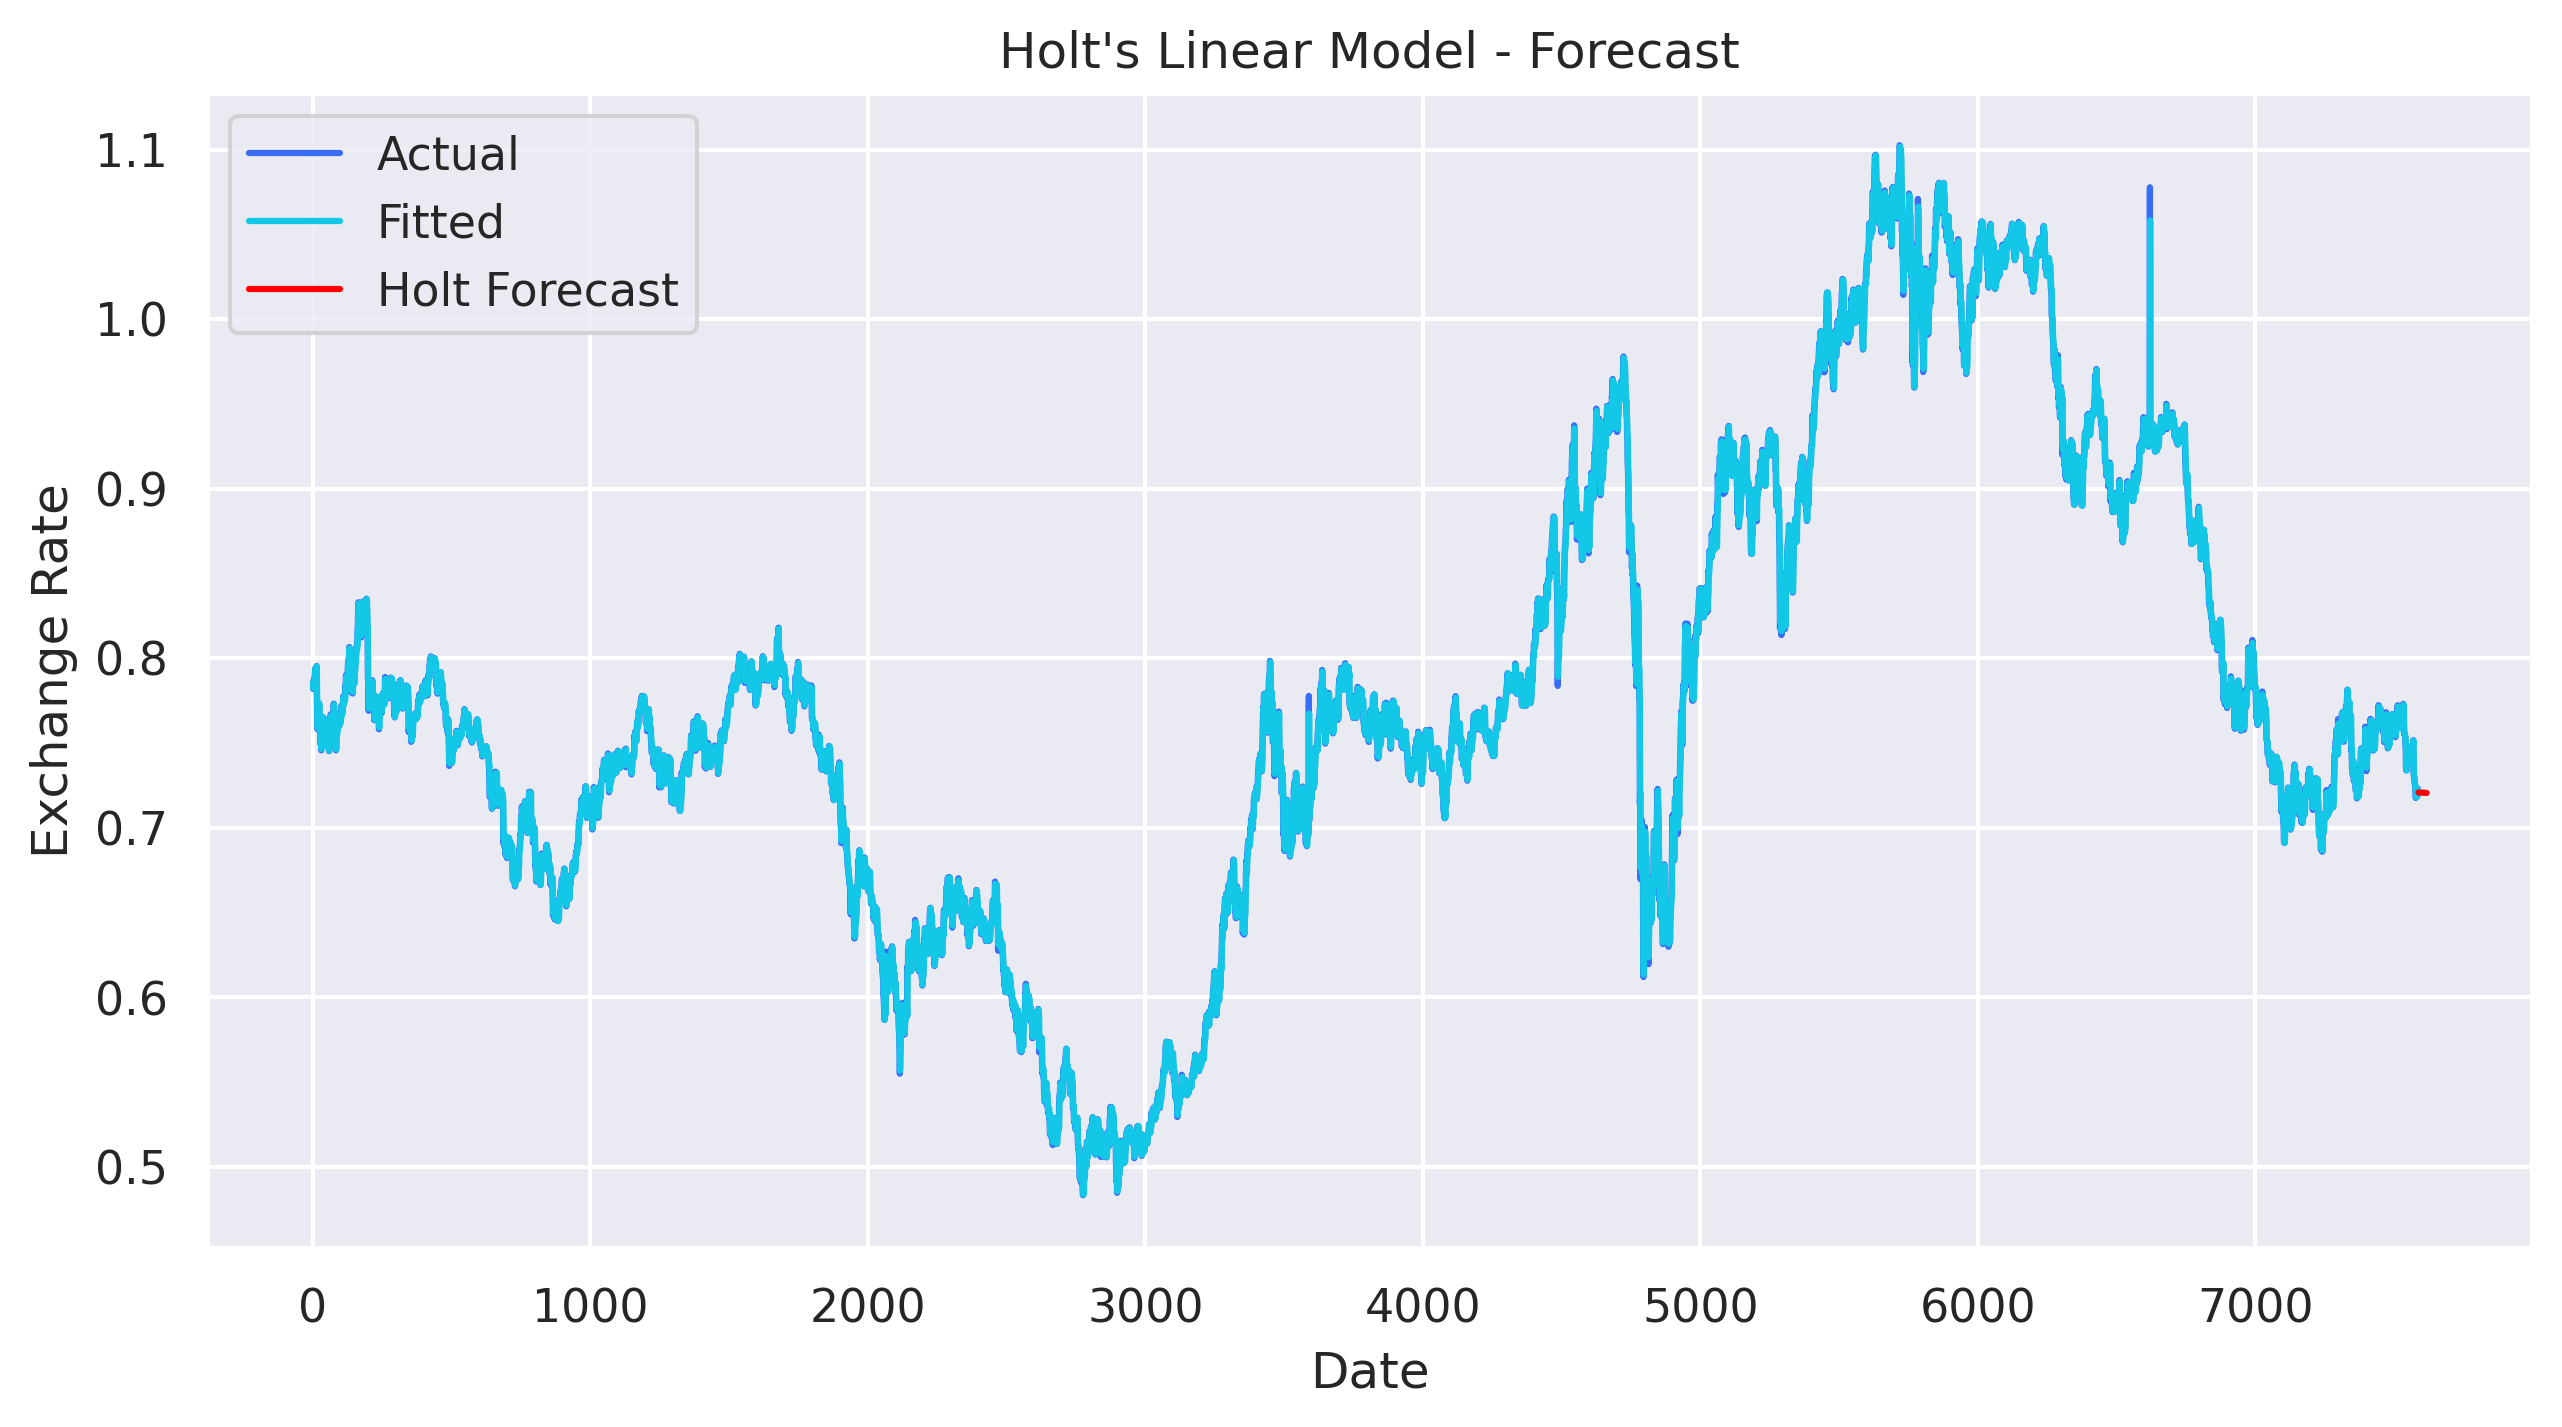

In [48]:
holt_forecast = holt_result.forecast(steps=30)

# Plot actual values and forecasts
plt.figure(figsize=(10, 5))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(holt_result.fittedvalues, label='Fitted')
plt.plot(holt_forecast, label='Holt Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title("Holt's Linear Model - Forecast")
plt.legend()
plt.show()

## **Evaluation and Comparison**

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate error metrics for ARIMA
arima_forecast = arima_result.get_forecast(steps=30).predicted_mean
arima_mae = mean_absolute_error(df['Ex_rate'][-30:], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], arima_forecast))
arima_mape = np.mean(np.abs((df['Ex_rate'][-30:] - arima_forecast) / df['Ex_rate'][-30:])) * 100

# Calculate error metrics for Holt's Linear Model
holt_mae = mean_absolute_error(df['Ex_rate'][-30:], holt_forecast)
holt_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], holt_forecast))
holt_mape = np.mean(np.abs((df['Ex_rate'][-30:] - holt_forecast) / df['Ex_rate'][-30:])) * 100

print(f"ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}")
print(f"Holt's Linear MAE: {holt_mae}, RMSE: {holt_rmse}, MAPE: {holt_mape}")

ARIMA MAE: 0.012724006489305202, RMSE: 0.016982710912755217, MAPE: nan
Holt's Linear MAE: 0.012755756156713368, RMSE: 0.017005229952751045, MAPE: nan
